In [213]:
import warnings
warnings.filterwarnings(action='ignore')

In [214]:
import pandas as pd

csv = pd.read_csv('middle.csv')

csv = csv.drop('측정년도', axis=1)
csv = csv.drop('초중고', axis=1)
csv = csv.drop('no', axis=1)
csv = csv.drop('name', axis=1)
csv = csv.drop('생년월일', axis=1)
csv = csv.drop('승', axis=1)
csv = csv.drop('패', axis=1)
csv = csv.drop('승률', axis=1)
csv = csv.drop('Ht', axis=1)
csv = csv.drop('Wt', axis=1)
csv = csv.drop('BMI', axis=1)
csv = csv.drop('서전트', axis=1)
csv = csv.drop('육각형', axis=1)
csv = csv.dropna(axis=1)
csv.columns

Index(['sex', '곧은근코어', '왼배코어', '오른배코어', '코트민첩성', '배근력', 'peakpwr', 'meanpwr',
       'minPwr', 'p_fatigue', '신장', '상완', '하완', '대퇴', '하퇴', '최대상완', '최대전완',
       '최대대퇴', '최대하퇴', '상완.1', '손목', '대퇴.1', '발목', '삼두근', '견갑골', '전완내측',
       '전완외측', '상장골', '대퇴.2', '종아리', '체중', '랭킹'],
      dtype='object')

In [215]:
csv.shape

(40, 32)

In [216]:
from tensorflow.keras import utils

X = csv.values[:,:31]
not_y = csv.values[:,31]

y = []
for i in not_y:
    if i < 129*0.5:
        y.append(0)
    else:
        y.append(1)
        
y = utils.to_categorical(y, 2)

In [217]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1004)
nX_train, nX_test, ny_train, ny_test = train_test_split(X, not_y, stratify=y, test_size=0.2, random_state=1004)

In [218]:
from sklearn.model_selection import GridSearchCV

def Grid_cv(model, params, X, y):
    grid_cv = GridSearchCV(model, param_grid=params, cv=3, n_jobs= -1)
    grid_cv.fit(X,y)
    return grid_cv

In [219]:
# 정렬 후 그래프 출력
import matplotlib.pyplot as plt

def sorting_plt(values):
    keys = csv.columns[:-1]
    lst = {}
    for i,j in zip(keys,values):
        lst[j] = i
    
    lst = sorted(lst.items(), reverse=0)
    
    plt.barh([i[1] for i in lst], [i[0] for i in lst])
    plt.show()

In [220]:
rf_params = {
    'n_estimators' : [i*10 for i in range(5,15)], # 기본 100
    'max_depth' : [i for i in range(3,9)], # 기본 6
    'min_samples_split' : [i for i in range(1,5)], # 기본 2
    'min_samples_leaf' : [i for i in range(0,5)] # 기본 1
}

gb_params = {
    'learning_rate' : [i*0.05 for i in range(1,20)], # 기본 0.1
    'n_estimators' : [i*10 for i in range(5,15)], # 기본 100
    'min_samples_split' : [i for i in range(1,5)], # 기본 2
    'min_samples_leaf' : [i for i in range(0,5)], # 기본 1
    'max_depth' : [i for i in range(3,9)] # 기본 6
}

ab_params = {
    'n_estimators' : [i*10 for i in range(2,8)], # 기본 50
    'learning_rate' : [i*0.1 for i in range(1,10)] # 기본 1.0
}

In [221]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0, n_jobs= -1)
rf_result = Grid_cv(rf, rf_params, nX_train, ny_train)

In [222]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=0)
gb_result = Grid_cv(gb, gb_params, nX_train, ny_train)

In [223]:
from sklearn.ensemble import AdaBoostClassifier

ab = AdaBoostClassifier(random_state=0)
ab_result = Grid_cv(ab, ab_params, nX_train, ny_train)

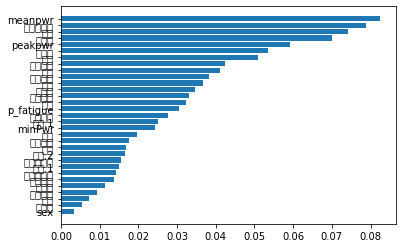

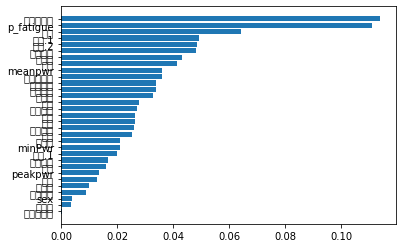

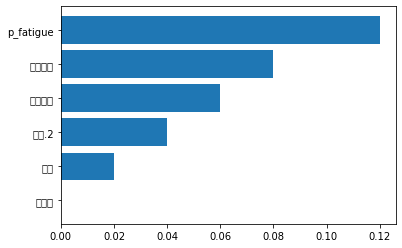

In [224]:
best_rf = RandomForestClassifier(random_state=0, n_jobs= -1)
best_gb = GradientBoostingClassifier(random_state=0)
best_ab = AdaBoostClassifier(random_state=0)
best_rf.fit(X,y)
best_gb.fit(X, not_y)
best_ab.fit(X, not_y)

sorting_plt(best_rf.feature_importances_)
sorting_plt(best_gb.feature_importances_)
sorting_plt(best_ab.feature_importances_)

In [225]:
df_rf = pd.DataFrame(rf_result.cv_results_)
df_rf['model'] = "RandomForest"

df_gb = pd.DataFrame(gb_result.cv_results_)
df_gb['model'] = "GradientBoosting"

df_ab = pd.DataFrame(ab_result.cv_results_)
df_ab['model'] = "AdaBoost"

In [226]:
def valuesort(values):
    keys = csv.columns[:-1]
    lst = {}
    for i,j in zip(keys,values):
        lst[j] = i

    lst = sorted(lst.items(), reverse=1)

    return lst

In [227]:
weight_rf = pd.DataFrame(valuesort(best_rf.feature_importances_), columns=['weight','title'])
weight_gb = pd.DataFrame(valuesort(best_gb.feature_importances_), columns=['weight','title'])
weight_ab = pd.DataFrame(valuesort(best_ab.feature_importances_), columns=['weight','title'])

In [228]:
weight_rf[['title','weight']].to_csv('./result/RandomForest_Weight.csv', index=0, encoding='utf-8-sig')
weight_gb[['title','weight']].to_csv('./result/GradientBoosting_Weight.csv', index=0, encoding='utf-8-sig')
weight_ab[['title','weight']].to_csv('./result/AdaBoost_Weight.csv', index=0, encoding='utf-8-sig')

In [229]:
df_1 = pd.concat([df_rf, df_gb])
df_2 = pd.concat([df_1, df_ab])

df_3 = pd.DataFrame()
df_3['model'] = df_2['model']
df_3['score'] = df_2['mean_test_score']
df_3['params'] = df_2['params']

df_3.to_csv('./result/0Model_Score.csv', index=0)